<a href="https://colab.research.google.com/github/danon6868/blastim-ml/blob/main/ml_cnn_day_16/LeNet5_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

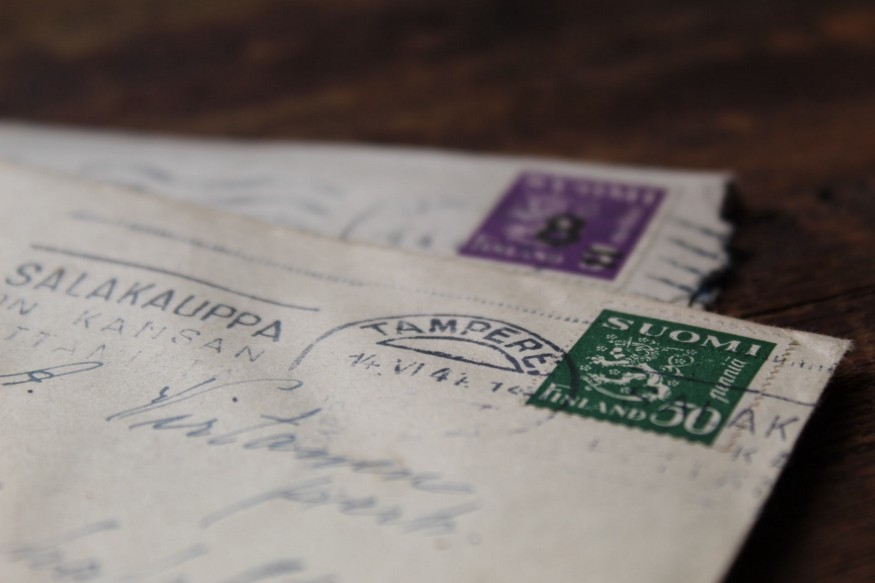

## Создаем LeNet-5 (Yann LeCun) в PyTorch

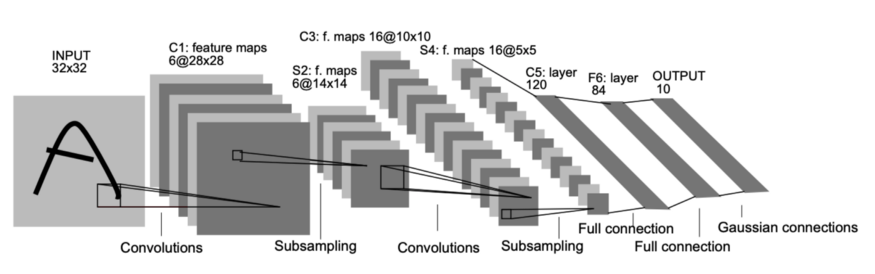

* Cx — convolution layer,
* Sx — subsampling (pooling) layer,
* Fx — fully-connected layer,
* x — index of the layer.

1. Слой 1 (С1): 6 ядер размером 5×5. Размер входного изображения 32×32×1. Активация гиперболический тангенс.

2. Слой 2 (S2): Average Pooling 2×2.

3. Слой 3 (С3): 16 ядер размером 5×5. Активация гиперболический тангенс.

4. Слой 4 (S4): Average Pooling 2×2.

5. Слой 5 (C5): 120 ядер размером 5×5. Активация гиперболический тангенс.

6. Слой 6 (F6): Полносвязный слой (120 входов и 84 выхода). Активация гиперболический тангенс.

7. Слой 7 (F7): Полносвязный слой (84 входа и 10 выходов).

In [ ]:
import numpy as np
import seaborn as sns
from IPython.display import clear_output
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Имплементируем модель

In [ ]:
## CODE IS HERE
class LeNet5(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)

        return logits, probs

In [ ]:
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 10

IMG_SIZE = 32
N_CLASSES = 10

In [ ]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    """
    Function for the training step of the training loop
    """

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader, model, criterion, device):
    """
    Function for the validation step of the training loop
    """

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss


def get_accuracy(model, dataloader, device):
    """
    model -
    dataloader -
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy


def plot_losses(train_losses, valid_losses):
    #clear_output(wait=True)
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    """
    Function defining the entire training loop
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, train_losses, valid_losses

## Создадим датасет

In [ ]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])


train_dataset = datasets.MNIST(root="mnist_data",
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root="mnist_data",
                               train=False,
                               transform=transforms)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)


clear_output()

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

09:21:28 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
09:22:05 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
09:22:43 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0543	Train accuracy: 98.59	Valid accuracy: 98.45
09:23:21 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0485	Train accuracy: 99.07	Valid accuracy: 98.41
09:23:58 --- Epoch: 4	Train loss: 0.0344	Valid loss: 0.0408	Train accuracy: 99.24	Valid accuracy: 98.78
09:24:36 --- Epoch: 5	Train loss: 0.0299	Valid loss: 0.0390	Train accuracy: 99.44	Valid accuracy: 98.71
09:25:14 --- Epoch: 6	Train loss: 0.0238	Valid loss: 0.0440	Train accuracy: 99.44	Valid accuracy: 98.64
09:25:52 --- Epoch: 7	Train loss: 0.0224	Valid loss: 0.0476	Train accuracy: 99.37	Valid accuracy: 98.55
09:26:29 --- Epoch: 8	Train loss: 0.0177	Valid loss: 0.0535	Train accuracy: 99.50	Valid accuracy: 98.45
09:27:08 --- Epoch: 9	Train loss: 0.0175	Valid loss: 0.0526	Trai

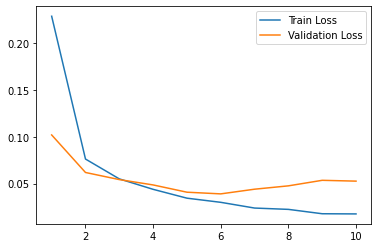

In [ ]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

## Визуализация предсказаний

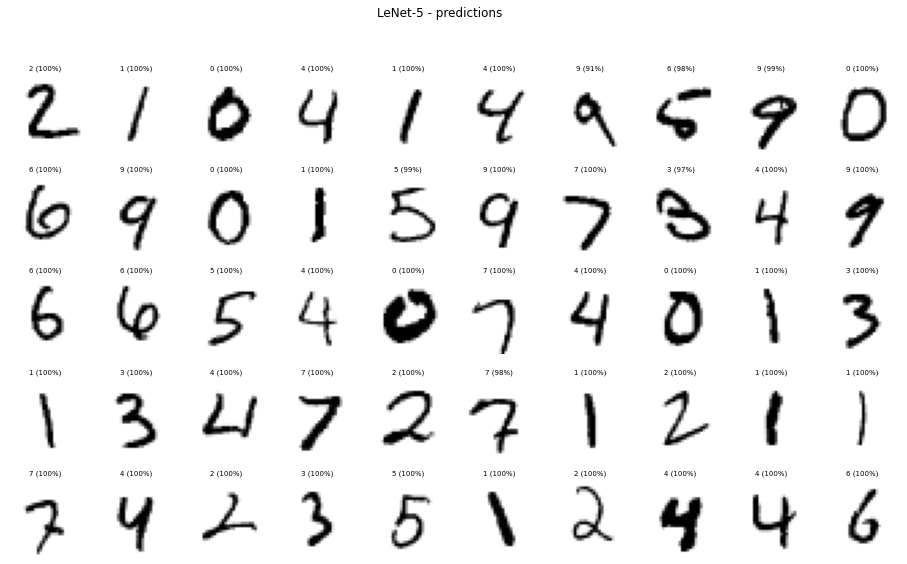

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(16, 9))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')

    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))

    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');